In [24]:
from datetime import datetime
import os
import tempfile
from glob import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from torch.utils import tensorboard

from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import monai
import torchmetrics
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ResizeWithPadOrCrop,
    RandAdjustContrast,
    RandBiasField,
    RandAffine,
    ScaleIntensity,
)
import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# monai.config.print_config()

In [113]:
class PPMIDataModule(pl.LightningDataModule):
    def __init__(self, 
                md_df, 
                batch_size, 
                root_dir,
                reshape_size = (128, 128, 128), 
                val_test_split = 0.4, 
                random_state = 42,
                agument = None):
        super().__init__()
        self.md_df = md_df
        self.batch_size = batch_size
        self.root_dir = root_dir
        self.reshape_size = reshape_size
        self.val_test_split = val_test_split
        self.random_state = random_state
        self.agument = agument
        self.subjects = None
        self.test_subjects = None
        self.preprocess = None
        self.transform = None
        self.train_set = None
        self.val_set = None
        self.test_set = None

    def get_subjects_list(self, md_df):
        subjects_list = []
        subjects_labels = []
        for i in range(len(md_df)):
            subj = md_df.iloc[i]
            if 'w/' in subj['Description']:
                subj_desc = subj['Description'].replace('w/', 'w_').replace(' ', '_')
            else:
                subj_desc = subj['Description'].replace(' ', '_')
                
            subj_dir = self.root_dir / str(subj['Subject']) / subj_desc
            for f in subj_dir.iterdir():
                if str(subj['Acq Date'].date()) in f.name:
                    subj_dir = f
                    break
            for f in subj_dir.iterdir(): 
                subj_dir = [f for f in f.iterdir()][0]
            subjects_list.append(str(subj_dir))
            if subj['Group'] == 'PD':
                subjects_labels.append(1)
            else:
                subjects_labels.append(0)

        return subjects_list, subjects_labels

    def get_max_shape(self, subjects):
        import numpy as np

        dataset = tio.SubjectsDataset(subjects)
        shapes = np.array([s.spatial_shape for s in dataset])
        return shapes.max(axis=0)

    def prepare_data(self):

        # split ratio train = 0.6, val = 0.2, test = 0.2
        self.md_df_train, md_df_rest = train_test_split(self.md_df, test_size=self.val_test_split, 
                                                            random_state=self.random_state, stratify=self.md_df.loc[:, 'Group'].values)
        self.md_df_val, self.md_df_test = train_test_split(md_df_rest, test_size=0.5,
                                                random_state=self.random_state, stratify=md_df_rest.loc[:, 'Group'].values)
                                                
        image_training_paths, labels_train = self.get_subjects_list(self.md_df_train)
        image_val_paths, labels_val = self.get_subjects_list(self.md_df_val)
        image_test_paths, labels_test = self.get_subjects_list(self.md_df_test)

        self.train_subjects = []
        for image_path, label in zip(image_training_paths, labels_train):
            # 'image' and 'label' are arbitrary names for the images
            subject = tio.Subject(image=tio.ScalarImage(image_path), label=torch.nn.functional.one_hot(torch.as_tensor(label), num_classes=2).float())
            self.train_subjects.append(subject)

        self.val_subjects = []
        for image_path, label in zip(image_val_paths, labels_val):
            # 'image' and 'label' are arbitrary names for the images
            subject = tio.Subject(image=tio.ScalarImage(image_path), label=torch.nn.functional.one_hot(torch.as_tensor(label), num_classes=2).float())
            self.val_subjects.append(subject)

        self.test_subjects = []
        for image_path, label in zip(image_test_paths, labels_test):
            subject = tio.Subject(image=tio.ScalarImage(image_path), label=torch.nn.functional.one_hot(torch.as_tensor(label), num_classes=2).float())
            self.test_subjects.append(subject)

    def get_preprocessing_transform(self):
        # Rescales intensities to [0, 1] and adds a channel dimension,
        # then resizes to the desired shape

        # preprocess = Compose(
        #     [ScaleIntensity(), 
        #     EnsureChannelFirst(), 
        #     ResizeWithPadOrCrop(self.reshape_size)
        #     ])
        preprocess = tio.Compose(
            [
                tio.RescaleIntensity((0, 1)),
                tio.CropOrPad(self.reshape_size),
                # tio.EnsureShapeMultiple(8),  # for the U-Net
                # tio.OneHot(),
            ]
        )
        return preprocess

    def get_augmentation_transform(self):

        # If no augmentation is specified, use the default one
        if self.agument == None:
            self.augment = tio.Compose([
                                        tio.RandomAffine(translation=10),
                                        tio.RandomElasticDeformation(p=0.1, num_control_points=7, max_displacement=10),
                                        tio.RandomGamma(p=0.5),
                                        tio.RandomNoise(p=0.5, mean=0.5, std=0.05), # p=0.5
                                        tio.RandomMotion(p=0.1), #, degrees=20, translation=20),
                                        tio.RandomBiasField(p=0.25),
                                        ])
                            # Compose(
                            # [RandAffine(prob=0.5,
                            #             translate_range=(5, 5, 5),
                            #             rotate_range=(np.pi * 4, np.pi * 4, np.pi *4 ),
                            #             scale_range=(0.15, 0.15, 0.15),
                            #             padding_mode='zeros')
                            # ])

    def setup(self, stage=None):
        
        # Assign train/val datasets for use in dataloaders
        self.preprocess = self.get_preprocessing_transform()
        self.get_augmentation_transform()
        self.transform = Compose([self.preprocess, self.augment])

        self.train_set = tio.SubjectsDataset(self.train_subjects, transform=self.transform)
        self.val_set = tio.SubjectsDataset(self.val_subjects, transform=self.preprocess)
        self.test_set = tio.SubjectsDataset(self.test_subjects, transform=self.preprocess)

    def train_dataloader(self):
        return DataLoader(self.train_set, self.batch_size, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_set, self.batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_set, self.batch_size, num_workers=2)

class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')
        self.train_auroc = torchmetrics.AUROC(task='binary')
        self.val_auroc = torchmetrics.AUROC(task='binary')
        self.train_f1 = torchmetrics.F1Score(task='binary', num_classes=2)
        self.val_f1 = torchmetrics.F1Score(task='binary', num_classes=2)

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        sch = ReduceLROnPlateau(optimizer, 'min',
                                factor=0.1, patience=10)
         #learning rate scheduler
        return {"optimizer": optimizer,
                "lr_scheduler": {"scheduler": sch,
                                 "monitor":"val_loss"}}

    def prepare_batch(self, batch):
        return batch["image"][tio.DATA], batch["label"]

    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        batch_size = len(y)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.train_acc(y_hat, y)
        self.train_auroc(y_hat, y)
        self.train_f1(y_hat, y)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.log("train_auroc", self.train_auroc, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.log("train_f1", self.train_f1, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
           
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        batch_size = len(y)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.val_acc(y_hat, y)
        self.val_auroc(y_hat, y)
        self.val_f1(y_hat, y)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.log("val_auroc", self.val_auroc, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.log("val_f1", self.val_f1, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)

        return loss

In [26]:
# data directory
root_dir = Path("/mnt/scratch/7TPD/mpm_run_acu/PPMI")
md_df = pd.read_csv(root_dir/'t1_3d_3t_1mm_pdhc_2_16_2023.csv')
md_df['Acq Date'] = md_df['Acq Date'].apply(pd.to_datetime)
md_df.sort_values(by='Acq Date', inplace=True)
first_acq_idx = md_df.duplicated(subset=['Subject'])
md_df_first = md_df.loc[~first_acq_idx, :]
print(f'Total: {len(md_df_first)} \n', f'PD: {len(md_df_first.loc[md_df_first.Group == "PD", :])} \n', f'HC: {len(md_df_first.loc[md_df_first.Group == "Control", :])}')

Total: 481 
 PD: 372 
 HC: 109


In [114]:
data = PPMIDataModule(md_df_first, batch_size=2, root_dir=root_dir, reshape_size=(200, 200, 200))
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

Training:   288
Validation:  96
Test:       97


In [115]:
train_dl = data.train_dataloader()

for subjects_batch in train_dl:
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break

print(type(inputs), inputs.shape, target, target.shape)

<class 'torch.Tensor'> torch.Size([2, 1, 200, 200, 200]) tensor([[0., 1.],
        [0., 1.]]) torch.Size([2, 2])


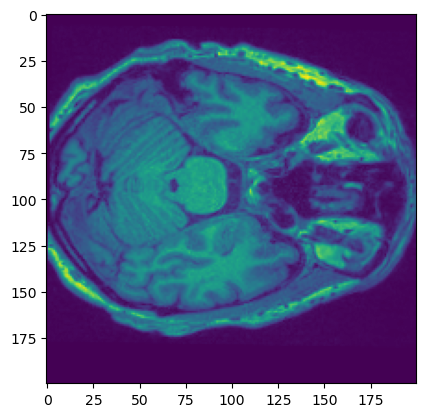

In [117]:
plt.imshow(inputs[1].cpu().detach().numpy()[0, :, :, 100]) # , (1, 2, 3, 0)

In [5]:
data.train_subjects[0]['image'][tio.DATA].shape

torch.Size([1, 192, 256, 256])

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

densenet = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2)

model = Model(densenet, torch.nn.CrossEntropyLoss(), 0.001, torch.optim.Adam)

early_stopping = pl.callbacks.early_stopping.EarlyStopping(
    monitor="val_loss", mode='min', patience=10,
)
trainer = pl.Trainer(
    accelerator='gpu', devices=1,
    precision=16,
    callbacks=[early_stopping],
    max_epochs=20,
)

2023-02-20 11:06:10,753 - Using 16bit None Automatic Mixed Precision (AMP)
2023-02-20 11:06:10,799 - GPU available: True (cuda), used: True
2023-02-20 11:06:10,800 - TPU available: False, using: 0 TPU cores
2023-02-20 11:06:10,800 - IPU available: False, using: 0 IPUs
2023-02-20 11:06:10,800 - HPU available: False, using: 0 HPUs


/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3. ...
  rank_zero_warn(


In [10]:
start = datetime.now()
print("Training started at", start)
trainer.fit(model=model, datamodule=data)
print("Training duration:", datetime.now() - start)

Training started at 2023-02-20 11:06:30.152854
2023-02-20 11:06:30,499 - You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-02-20 11:06:30,530 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-02-20 11:06:30,541 - 
  | Name        | Type             | Params
-------------------------------------------------
0 | net         | DenseNet121      | 11.2 M
1 | criterion   | CrossEntropyLoss | 0     
2 | train_acc   | BinaryAccuracy   | 0     
3 | val_acc     | BinaryAccuracy   | 0     
4 | train_auroc | BinaryAUROC      | 0     
5 | val_auroc   | BinaryAUROC      | 0     
6 | train_f1    | BinaryF1Score    | 0     
7 | val_f1      | BinaryF1Score    | 0     
----------------------

Sanity Checking: 0it [00:00, ?it/s]

/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training duration: 0:45:45.930016
